# Final Project: Online Retail Data Anaysis
Description: This project is to analyse the Transaction Level Retail Data for the customers and recommend additional products for the customers
    
    
Author: Rajesh Kumar
Date: 12/16/2017

# Basic Data Loading


In [1]:
# NumPy for numerical computing
import numpy as np #linear algebra
# Pandas for DataFrames
import pandas as pd #data processing
# Matplotlib for visualization
import matplotlib.pyplot as plt
# Seaborn for easier visualization
import seaborn as sns

#sklearn to do item-item clusterring 
from sklearn import metrics
from sklearn.cluster import KMeans


In [2]:
##
# Read the CSV File
##

data = pd.read_csv('onlineretaildata.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [3]:
##
# Data Needs Cleanup
##

#data1 = data.loc[data['CustomerID'] != np.NaN & data['Quantity'].astype('int64') > 0 & data['StockCode'].astype(str).str.isdigit()]

# Cleanup data where there is no customer id associated
data1 = data.loc[data['CustomerID'] != np.NaN]

# Cleanup data where country is not UK
#data1 = data1.loc[data1.Country == 'United Kingdom']

# Cleanup data where quantity is negative for returns
data1 = data1.loc[data1.Quantity > 0]

# Cleanup data where Item is invalid
data1 = data1.loc[data1.StockCode != 'POST']
data1 = data1.loc[data1.StockCode != '85123A']
data1 = data1.loc[data1.StockCode != '85099B']
data1 = data1.loc[data1.StockCode != '82494L']
data1 = data1.loc[data1.StockCode != '85099B']
data1 = data1.loc[data1.StockCode != '84029G']
data1 = data1.loc[data1.StockCode != '85099C']
data1 = data1.loc[data1.StockCode != '85099F']
data1 = data1.loc[data1.StockCode != 'DOT']

#data1 = data1.loc[data1.CustomerID.dropna()]

# Compute the total value for each item in each transactions
data1["ItemPrice"] = data1["UnitPrice"] * data1["Quantity"]

# Drop unneccessary columns from the data
data1 = data1.drop(columns=["Description", "Country", "InvoiceDate", "InvoiceNo", "UnitPrice", "Quantity"])



#data1 = data1.loc(data1.StockCode.str.isdigit())
data1.info()


# Dump clean data to excel for a quick checkup
data1.to_csv("onlinedatatestdump.csv")
data1.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521895 entries, 1 to 541908
Data columns (total 3 columns):
StockCode     521895 non-null object
CustomerID    390687 non-null float64
ItemPrice     521895 non-null float64
dtypes: float64(2), object(1)
memory usage: 15.9+ MB


,StockCode,CustomerID,ItemPrice
1,71053,17850.0,20.34
2,84406B,17850.0,22.00
4,84029E,17850.0,20.34


In [27]:
## 
# Find top n items as our analysis needs to focus only on these 
##

print data1['StockCode'].agg(['count'])
print data1['CustomerID'].agg(['count'])

# Group by Items and count the total times these appear in data1 dataframe
topitems = data1.groupby(['StockCode']).size().reset_index(name='counts')

#save saved soted values
topitems = topitems.sort_values(['counts'], ascending=[False])

# Values dumps a NP array
topitems = topitems['StockCode'].head(100).values
topitems

count    521895
Name: StockCode, dtype: int64
count    390687
Name: CustomerID, dtype: int64


array(['22423', '47566', '20725', '84879', '22197', '22720', '21212',
       '20727', '22383', '22457', '23203', '22386', '22469', '22086',
       '21931', '22411', '22382', '20728', '22961', '23298', '22960',
       '22666', '23209', '22384', '82482', '22993', '22699', '22727',
       '23206', '20724', '23084', '22178', '22697', '20726', '21080',
       '22726', '23199', '22077', '22139', '21034', '22138', '22470',
       '21790', '23301', '84946', '22629', '23201', '20914', '22355',
       '23202', '21977', '23245', '22112', '21929', '22630', '21181',
       '20712', '84991', '21731', '22722', '20719', '21232', '22910',
       '21175', '21928', '22090', '23355', '21754', '22698', '22728',
       '22111', '22558', '23300', '23207', '22356', '21733', '22379',
       '22326', '23284', '84978', '21166', '22659', '23344', '22624',
       '20723', '22554', '21930', '22907', '20685', '22467', '84380',
       '22385', '22662', '84378', '22551', '22966', '23208', '82484',
       '85152', '212

# Data Analysis

In [26]:
## Find all customers who bought top 100 items
# Number of times top 100 items were bought by the customers
# Number of customers who bought 100 iems
##

print data1.loc[data1.StockCode.isin(topitems)].size

customeritemdf = data1.loc[data1.StockCode.isin(topitems)]

uniqueVals = customeritemdf["CustomerID"].unique()

#Print unique values for the data
print uniqueVals.size


<class 'pandas.core.frame.DataFrame'>
Int64Index: 521895 entries, 1 to 541908
Data columns (total 3 columns):
StockCode     521895 non-null object
CustomerID    390687 non-null float64
ItemPrice     521895 non-null float64
dtypes: float64(2), object(1)
memory usage: 35.9+ MB
None
287466
3919


In [42]:
## Reduce dataframe to only have top n items
data1 = data1.loc[data1.StockCode.isin(topitems)]
data1.info()
data1.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 10012 entries, 9 to 95549
Data columns (total 3 columns):
StockCode     10012 non-null object
CustomerID    7452 non-null float64
ItemPrice     10012 non-null float64
dtypes: float64(2), object(1)
memory usage: 312.9+ KB


,StockCode,CustomerID,ItemPrice
9,84879,13047.0,54.08
17,21754,13047.0,17.85
18,21755,13047.0,17.85
21,22960,13047.0,25.50
46,22086,13748.0,204.00


In [43]:
## Group by Customers and Items for Total price spent by customer
aggregatedf = []
aggregatedf = data1.groupby(['CustomerID', 'StockCode']).agg(['sum'])
aggregatedf.reset_index('CustomerID')
aggregatedf.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5794 entries, (12747.0, 21754) to (18283.0, 84378)
Data columns (total 1 columns):
(ItemPrice, sum)    5794 non-null float64
dtypes: float64(1)
memory usage: 71.7+ KB


In [44]:
aggregatedf.head(10)

ItemPrice
                           sum
CustomerID StockCode          
12747.0    21754         17.85
           82482         61.20
           84879         67.60
12748.0    20685         15.90
           20725          4.95
           20727          6.60
           21034         15.20
           21080          1.70
           21181          2.10
           21232          5.00

In [45]:
dataunstack = aggregatedf.unstack()
dataunstack.to_csv('UnstackedData2.csv')
#dataunstack.info()
dataunstack.head(10)

#dataunstack = aggregatedf.reset_index().pivot(columns='StockCode', index='CustomerID', values='ItemPrices')

ItemPrice                                                           \
                 sum                                                            
StockCode      20685 20725 20727  21034 21080 21181 21212  21232 21479  21485   
CustomerID                                                                      
12747.0          NaN   NaN   NaN    NaN   NaN   NaN   NaN    NaN   NaN    NaN   
12748.0         15.9  4.95   6.6  15.20   1.7   2.1   NaN   5.00   7.5  14.85   
12820.0          NaN   NaN   NaN    NaN   NaN   NaN   NaN    NaN   NaN    NaN   
12826.0          NaN   NaN  16.5    NaN  10.2   NaN  13.2    NaN  30.0    NaN   
12836.0          NaN   NaN   NaN    NaN   NaN   NaN   NaN    NaN   NaN  19.80   
12838.0          NaN   NaN   NaN    NaN   NaN   NaN   1.1    NaN   NaN    NaN   
12839.0          NaN   NaN   NaN    NaN   NaN   NaN   NaN  66.25   NaN    NaN   
12841.0          NaN   NaN   NaN   0.95   NaN   NaN   NaN    NaN   NaN    NaN   
12852.0          NaN   NaN   NaN    NaN   NaN   NaN   NaN    NaN   NaN    NaN   
12853.0         31.8   NaN   NaN    NaN   NaN   NaN   NaN    NaN   NaN    NaN   

            ...                                                             \
            ...                                                              
StockCode   ...    22837 22960 22961  22988 79321 82482 84378  84879 84946   
CustomerID  ...                                                              
12747.0     ...      NaN   NaN   NaN    NaN   NaN  61.2   NaN  67.60   NaN   
12748.0     ...      NaN   NaN  1.45   8.75  59.4   NaN   NaN  76.36   NaN   
12820.0     ...      NaN   NaN   NaN    NaN   NaN   NaN   NaN    NaN   NaN   
12826.0     ...    18.60   NaN   NaN    NaN   NaN   NaN   NaN    NaN   NaN   
12836.0     ...      NaN   NaN   NaN    NaN   NaN   NaN   NaN    NaN   NaN   
12838.0     ...    13.95   NaN  4.35    NaN   NaN   NaN   NaN    NaN   NaN   
12839.0     ...    18.60   NaN   NaN    NaN   NaN   NaN   NaN    NaN   NaN   
12841.0     ...      NaN   NaN   NaN    NaN  83.2   NaN   7.5    NaN   NaN   
12852.0     ...      NaN   NaN   NaN    NaN   NaN   NaN   NaN    NaN   NaN   
12853.0     ...      NaN   NaN   NaN  15.00   NaN   NaN  15.0    NaN   NaN   

                   
                   
StockCode   84992  
CustomerID         
12747.0       NaN  
12748.0      1.65  
12820.0     13.20  
12826.0       NaN  
12836.0       NaN  
12838.0       NaN  
12839.0       NaN  
12841.0       NaN  
12852.0       NaN  
12853.0       NaN  

[10 rows x 50 columns]

In [46]:
#remove Nan
dataready = dataunstack.fillna(0)
print dataready.index.size
dataready.head(10)


1149


ItemPrice                                                           \
                 sum                                                            
StockCode      20685 20725 20727  21034 21080 21181 21212  21232 21479  21485   
CustomerID                                                                      
12747.0          0.0  0.00   0.0   0.00   0.0   0.0   0.0   0.00   0.0   0.00   
12748.0         15.9  4.95   6.6  15.20   1.7   2.1   0.0   5.00   7.5  14.85   
12820.0          0.0  0.00   0.0   0.00   0.0   0.0   0.0   0.00   0.0   0.00   
12826.0          0.0  0.00  16.5   0.00  10.2   0.0  13.2   0.00  30.0   0.00   
12836.0          0.0  0.00   0.0   0.00   0.0   0.0   0.0   0.00   0.0  19.80   
12838.0          0.0  0.00   0.0   0.00   0.0   0.0   1.1   0.00   0.0   0.00   
12839.0          0.0  0.00   0.0   0.00   0.0   0.0   0.0  66.25   0.0   0.00   
12841.0          0.0  0.00   0.0   0.95   0.0   0.0   0.0   0.00   0.0   0.00   
12852.0          0.0  0.00   0.0   0.00   0.0   0.0   0.0   0.00   0.0   0.00   
12853.0         31.8  0.00   0.0   0.00   0.0   0.0   0.0   0.00   0.0   0.00   

            ...                                                             \
            ...                                                              
StockCode   ...    22837 22960 22961  22988 79321 82482 84378  84879 84946   
CustomerID  ...                                                              
12747.0     ...     0.00   0.0  0.00   0.00   0.0  61.2   0.0  67.60   0.0   
12748.0     ...     0.00   0.0  1.45   8.75  59.4   0.0   0.0  76.36   0.0   
12820.0     ...     0.00   0.0  0.00   0.00   0.0   0.0   0.0   0.00   0.0   
12826.0     ...    18.60   0.0  0.00   0.00   0.0   0.0   0.0   0.00   0.0   
12836.0     ...     0.00   0.0  0.00   0.00   0.0   0.0   0.0   0.00   0.0   
12838.0     ...    13.95   0.0  4.35   0.00   0.0   0.0   0.0   0.00   0.0   
12839.0     ...    18.60   0.0  0.00   0.00   0.0   0.0   0.0   0.00   0.0   
12841.0     ...     0.00   0.0  0.00   0.00  83.2   0.0   7.5   0.00   0.0   
12852.0     ...     0.00   0.0  0.00   0.00   0.0   0.0   0.0   0.00   0.0   
12853.0     ...     0.00   0.0  0.00  15.00   0.0   0.0  15.0   0.00   0.0   

                   
                   
StockCode   84992  
CustomerID         
12747.0      0.00  
12748.0      1.65  
12820.0     13.20  
12826.0      0.00  
12836.0      0.00  
12838.0      0.00  
12839.0      0.00  
12841.0      0.00  
12852.0      0.00  
12853.0      0.00  

[10 rows x 50 columns]

In [47]:
dataready.values


array([[  0.  ,   0.  ,   0.  , ...,  67.6 ,   0.  ,   0.  ],
       [ 15.9 ,   4.95,   6.6 , ...,  76.36,   0.  ,   1.65],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,  13.2 ],
       ..., 
       [  0.  ,   0.  ,   0.  , ...,  81.12,   0.  ,  13.2 ],
       [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.  ,   0.  ,   1.65, ...,   0.  ,   0.  ,   0.  ]])

In [ ]:
customeritem = []
z = 5

for x in dataready.index:
    z -=1
    if z>0:
        #print x
        #print dataready.loc[dataready.index == x]
        customeritem = customeritem.append(x)
        customeritem = customeritem.append(dataready.loc[dataready.index == x])
        print customeritem


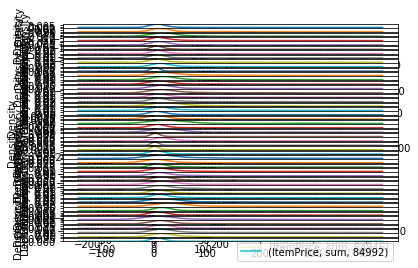

In [48]:
#data1.StockCode.unique()
dataunstack.plot(kind="density", subplots=True, sharex=False)
plt.show()

In [68]:
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans

sample_df_train, sample_df_test = train_test_split(dataready, train_size=0.8)

#print sample_df_test
cluster = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1)
cluster.fit(sample_df_train)
result = cluster.predict(sample_df_test)
print result.size
print set(result)



230
set([0, 2, 3, 4])


In [71]:
from sklearn.cross_validation import train_test_split

sample_df_train, sample_df_test = train_test_split(dataready, train_size=0.8)

#print sample_df_test
cluster = KMeans(n_clusters=8, init='k-means++', n_init=5, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1)
#cluster.fit(sample_df_train)
cluster.fit(dataready)
result = cluster.predict(dataready)
print result.size
result

1149


array([0, 0, 0, ..., 0, 0, 0])

In [72]:
set(result)

{0, 1, 2, 3, 4, 5, 6, 7}

In [73]:
dataready['ClusterID'] = result
dataready.head(3)

ItemPrice                                                         \
                 sum                                                          
StockCode      20685 20725 20727 21034 21080 21181 21212 21232 21479  21485   
CustomerID                                                                    
12747.0          0.0  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.00   
12748.0         15.9  4.95   6.6  15.2   1.7   2.1   0.0   5.0   7.5  14.85   
12820.0          0.0  0.00   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.00   

              ...                                                             \
              ...                                                              
StockCode     ...    22960 22961 22988 79321 82482 84378  84879 84946  84992   
CustomerID    ...                                                              
12747.0       ...      0.0  0.00  0.00   0.0  61.2   0.0  67.60   0.0   0.00   
12748.0       ...      0.0  1.45  8.75  59.4   0.0   0.0  76.36   0.0   1.65   
12820.0       ...      0.0  0.00  0.00   0.0   0.0   0.0   0.00   0.0  13.20   

           ClusterID  
                      
StockCode             
CustomerID            
12747.0            0  
12748.0            0  
12820.0            0  

[3 rows x 51 columns]

In [74]:
##
# Try to do PCA on the data
##

In [76]:
##
# Put the values in visualization
##
npdisplaydata = dataready.values

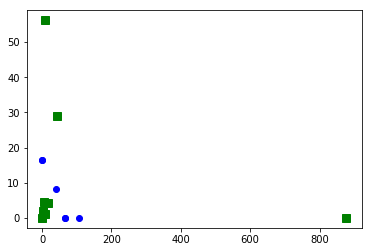

In [78]:
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq

# data generation
#data = vstack((rand(150,2) + array([.5,.5]),rand(150,2)))

# computing K-Means with K = 2 (2 clusters)
centroids,_ = kmeans(npdisplaydata,8)
# assign each sample to a cluster
idx,_ = vq(npdisplaydata,centroids)

# some plotting using numpy's logical indexing
plot(npdisplaydata[idx==0,0],npdisplaydata[idx==0,1],'ob',
     npdisplaydata[idx==1,0],npdisplaydata[idx==1,1],'or')
plot(centroids[:,0],centroids[:,1],'sg',markersize=8)
show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 10
#for customer in dataready

data = np.random.random((N, 4))
labels = ['point{0}'.format(i) for i in range(N)]

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    data[:, 0], data[:, 1], marker='o', c=data[:, 2], s=data[:, 3] * 1500,
    cmap=plt.get_cmap('Spectral'))

for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import mlab
import Pycluster as pc

# make fake user data
users = np.random.normal(0, 10, (20, 5))

# cluster
clusterid, error, nfound = pc.kcluster(dataready, nclusters=8, transpose=0, 
                                       npass=10, method='a', dist='e')
centroids, _ = pc.clustercentroids(dataready, clusterid=clusterid)

# reduce dimensionality
users_pca = mlab.PCA(dataready)
cutoff = users_pca.fracs[1]
users_2d = users_pca.project(dataready, minfrac=cutoff)
centroids_2d = users_pca.project(centroids, minfrac=cutoff)

# make a plot
colors = ['red', 'green', 'blue']
plt.figure()
plt.xlim([users_2d[:,0].min() - .5, users_2d[:,0].max() + .5])
plt.ylim([users_2d[:,1].min() - .5, users_2d[:,1].max() + .5])
plt.xticks([], []); plt.yticks([], []) # numbers aren't meaningful

# show the centroids
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], marker='o', c=colors, s=100)

# show user numbers, colored by their cluster id
for i, ((x,y), kls) in enumerate(zip(users_2d, clusterid)):
    plt.annotate(str(i), xy=(x,y), xytext=(0,0), textcoords='offset points',
                 color=colors[kls])

In [3]:
from sklearn.manifold import TSNE

In [2]:
from skdata.mnist.views import OfficialImageClassification

In [6]:
from sklearn.manifold import bh_sne

ImportError: cannot import name bh_sne

In [2]:
from skdata.mnist.views import OfficialImageClassification
from matplotlib import pyplot as plt
from tsne import bh_sne

# load up data
data = OfficialImageClassification(x_dtype="float32")
x_data = data.all_images
y_data = data.all_labels

# convert image data to float64 matrix. float64 is need for bh_sne
x_data = np.asarray(x_data).astype('float64')
x_data = x_data.reshape((x_data.shape[0], -1))

# For speed of computation, only run on a subset
n = 20000
x_data = x_data[:n]
y_data = y_data[:n]

# perform t-SNE embedding
vis_data = bh_sne(x_data)

# plot the result
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]

plt.scatter(vis_x, vis_y, c=y_data, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

ImportError: No module named skdata.mnist.views

# Train and Test split

# Cluster Analysis